# Backtesting in the Algorithmic Trading framework #

### Abstract ###

In this notebook we explore some notions behind programmatic backtesting. We present various methods employed in backtesting trading strategies, we explain the technicals and the major challenges when constructing and using a backtesting engine. We present this work using the cryptocurrency electronic market, beacuse of the data availability and the high market liquidity. We present the characteristic of a Vectorized Backtesting method, followed by an Event Driven Backtesting method. 

### Introduction ###

In the context of Algorithmic Trading the key features are entries and exits. Algorithmic Trading is objective, metrics driven and has a pre-planned risk management. Whereas discretionary trading can be rather intuitive, event driven, opinion driven and mostly targets high profits no matter the risks. A trade entry rule can be *endogenous* or *exogenous*. The first type of entry are characterized only by price and volumes whereas the second type is characterized by some other data correlated to the price. In this notebook we will only use *endogenous* data, assuming the **"Efficient Market Hypothesis"**, where by that, loosely speaking, we assume that all other exogenous factors influencing the price are embedded in the stochastic process represented by the price time series. The strategy we are going to analyse and *backtest* is a ***momentum based strategy***. A momentum is a phase or period in which as asset appears to be moving based on past changes in prices rather than due to any specific fundamentals or views. When prices moves higher in reaction to higher prices is known as *bull phase*; when prices move lower just because they would been going lower it is known as *bear phase*. It can be a complex problem to correctly asses a trend in a forest of prices. In various funds, and research institution it has been shown that the slope of rolling averages or moving averages can tell wether an asset is in a uptrend or downtrend. A very common way to obtain a momentum signal is to look for moving average crossover. This means computing two moving averages of different lengths, and waiting for one to cross the other. The direction of the cross will indicate the direction of the momentum.

The algorithm we wish to *backtest* is as follows:

Denote by MA(10) the moving average of rolling window 10 bars, and denote by MA(20) the moving average of rolling window 20 bars. 

**if** $MA(10) > MA(20)$ **Then buy(asset)** 
**if** $MA(10) < MA(20)$ **Then sell(asset)**

The rolling windows of the two moving averages are given. However, with some optimization techniques they may be tuned differently for maximizing profit. The tuning of the moving averages windows is encoded into Backtesting. 

A Backtest is a collection of functions assessing the performance of a given strategy on historical data. A backtest tests the viability of a strategy. Involves simulating the performance of a given strategy on historical data. In more simple words it asses how well a given strategy would have performed on previous price data. The importance of a *good* programmatic backtest engine relies on helping traders to build a picture of the flaws and strength of a given strategy.

When backtesting a trading strategy many issues arises: like data snooping or overfitting with an excessive tuning of the parameters, and most importantly time BIAS like lookahead BIAS.

Generally speaking a backtesting engine works in the following steps:

- Apply trading rules to historical data set.
- Simulate an hypothetical trade scenario to record results of the given trading rule.
- Measure hypothetical performance of the given trading rule.

The most common performance metrics employed in a backtest are:

- Number of Trades.
- Number of Winning Trades.
- Number of Loosing Trades.
- Ratio of profitable trades.
- Ratio of unprofitable trades.
- Sharpe ratio: defined as the returns of the strategy over the risk (standard deviation of the strategy's returns).


Other important features when constructing a backtest are certainly:

- Trading costs (fees, commissions and iceberg costs), these will be reflected in the prices at which the trader transacts.
- Plotting and tracking the PnL against a benchmark.

The aim of the backtest is to provide the building block for developing a steady stable trend in the PnL curve, rather than wild oscillation even if less profitable.

# Part 0: Collecting the Data 

In this section we briefly explain how to get the data. Clearly, from the above discussion we understand the importance of the data. We retrieve some data with one minute granularity from the Binance API.

In [1]:
#import the relevant python modules for this session

import pandas as pd #lybrary for manuevering the data;
import numpy as np #lybrary for vector operation and mathematical functions;
import matplotlib.pyplot as plt #data visualization;
from binance.client import Client #This is to access the Binance API;
plt.style.use("seaborn") #the matplotlib style of the plots, just for personal taste :) 
%load_ext autoreload 
%autoreload 2

#To access the data we need an API key that can be retrieved on binance.testnet. 
#I made one for this presentation on a simulated account

api_key = "82358fba3ec8bf87816d4f5590460d4001824e7ced03fc54d3ac4628919964be"
secret_key = "40943bfd8deaf625a753cf46a857546cf53c16f58ac1e907a94476a73da0595c"

client = Client(api_key = api_key, 
                api_secret = secret_key, 
                tld = "com", 
                testnet = True) # Testnet!!!

In [2]:
#what can we trade on this futures account?

client.get_all_tickers()

[{'symbol': 'BNBBUSD', 'price': '383.60000000'},
 {'symbol': 'BTCBUSD', 'price': '38865.40000000'},
 {'symbol': 'ETHBUSD', 'price': '2581.53000000'},
 {'symbol': 'LTCBUSD', 'price': '100.40000000'},
 {'symbol': 'TRXBUSD', 'price': '0.06055000'},
 {'symbol': 'XRPBUSD', 'price': '0.72050000'},
 {'symbol': 'BNBUSDT', 'price': '383.30000000'},
 {'symbol': 'BTCUSDT', 'price': '38851.49000000'},
 {'symbol': 'ETHUSDT', 'price': '2582.21000000'},
 {'symbol': 'LTCUSDT', 'price': '100.40000000'},
 {'symbol': 'TRXUSDT', 'price': '0.06055000'},
 {'symbol': 'XRPUSDT', 'price': '0.72010000'},
 {'symbol': 'BNBBTC', 'price': '0.00986600'},
 {'symbol': 'ETHBTC', 'price': '0.06644800'},
 {'symbol': 'LTCBTC', 'price': '0.00258300'},
 {'symbol': 'TRXBTC', 'price': '0.00000156'},
 {'symbol': 'XRPBTC', 'price': '0.00001853'},
 {'symbol': 'LTCBNB', 'price': '0.26070000'},
 {'symbol': 'TRXBNB', 'price': '0.00015850'},
 {'symbol': 'XRPBNB', 'price': '0.00187900'}]

In [3]:
#How do we get historical spot market data of BTCUSDT ?

bars = client.get_historical_klines(symbol = 'BTCUSDT', interval = '1m',
                                        start_str = '2022-03-04', end_str = '2022-03-07', limit = 1000)

#This will save the data in a Json format, that needs to be translated into a pandas format

In [4]:
#to give an example:

bars[0]

[1646352000000,
 '42453.60000000',
 '42456.87000000',
 '42415.22000000',
 '42428.36000000',
 '2.58481800',
 1646352059999,
 '109714.27209089',
 92,
 '0.58781200',
 '24944.69972956',
 '0']

In order to clean the above data, we need to gather informations on what are we pulling from the API. To do so, we can read the kline/Candlestick Data github documentation provided by binance https://binance-docs.github.io/apidocs/spot/en/#kline-candlestick-streams .

In [5]:
def get_history(symbol, interval, start, end = None):
    
    '''Gets historical futures data, and wraps them into a pandas format.'''
    
    bars = client.futures_historical_klines(symbol = symbol, interval = interval,
                                        start_str = start, end_str = end, limit = 1000)
    df = pd.DataFrame(bars)
    df["Date"] = pd.to_datetime(df.iloc[:,0], unit = "ms")
    df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume",
                  "Clos Time", "Quote Asset Volume", "Number of Trades",
                  "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
    df.set_index("Date", inplace = True)
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors = "coerce")
    
    return df

In [6]:
data = get_history('BTCUSDT', interval = '1m', start = '2022-03-04')

data.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2022-03-04 00:00:00,42454.5,42505.1,38099.3,38099.3,148.316
2022-03-04 00:01:00,42430.8,44402.4,42298.6,42458.8,136.589
2022-03-04 00:02:00,42452.3,42501.0,42417.6,42453.7,71.969
2022-03-04 00:03:00,42462.0,42498.7,42448.6,42459.3,100.470
2022-03-04 00:04:00,42462.1,46409.5,42448.6,46409.5,118.795


In [7]:
#we save these data in a csv file format for later use.

data.to_csv('bitcoin_minute.csv')

# Part 1: Vectorized Backtesting

A vectorized backtest is a backtesting engine that organizes historical data into vectors and matrices. The simulation of the trading strategy is done via linear algebra operations. Linear algebra from a computer science perspective, provides a natural and efficient language for most of the computations. That means that in the case of backtesting, provides a fast way and very efficient way to give some insight on the performance of a trading strategy.

The class we are going to use is in the CrossoverVectorized.py module whose methods are explained in the documentation and most of them are inherited from the CoreModules folder modules.

The most important methods are on_data() and test_strategy(). The first one is where vectorization is performed, indeed the method encapsules the trading conditions for the signal organising them into a matrix (in a *pythonian jargon* this matrix is referred as a pandas dataframe). The method test_strategy() will perform the backtest, acting on the previously mentioned pandas dataframe, by looping the historical data and assessing the performance based on the signal originating from the trading strategy logic. In all the class the logarithmic returns are considered to asses performance. The reason behind logarithmic returns relies on the *quasi log-normality* of the stochastic process associated to prices. 

Furthermore, as a remark, since we are performing a backtest on futures instruments, then in the code there is a session for adding leverage, however since we are more focusing on the backtest as a tool itself we will henceforth assume a leverage of one (no leverage), and we manipulate the futures trading data exactly as in the spot market. Moreover, setting up a leverage or a leverage over time will define a new strategy which will not be the object of this discussion.

In [8]:
#lets import the relevant module for this session

from CrossoverVectorized import DoubleCrossover



#lets instantiate the object class

crossoverVec = DoubleCrossover(symbol = 'BTCUSDT', #symbol of the cryptocurrency
                               interval = '1m', #granularity of the bar
                               start = '2022-03-04', #starting date, ending date is optional
                               tc = 0.001, #trading costs (just the commissions, other costs are omitted)
                               amount = 10000, #trader amount to be invested
                               binance = True) #data provider

In [9]:
#lets look directly at the test of the strategy
emas = [10,20]

crossoverVec.test_strategy(emas = emas)

STRATEGY PERFORMANCE | INSTRUMENT = BTCUSDT |
----------------------------------------------------------------------------------------------------
TRADING PERFORMANCE MEASURES:


Number of Trades: 660.0
Number of Winners: 283
Number of Loosers: 377.0


Win Ratio: 0.4288
Loose Ratio: 0.5712


Terminal Wealth: 10201.6572
Maximum Drawdown: -0.291
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         0.7724
Multiple (Buy-and-Hold Benchmark):     1.0202
--------------------------------------
Out-/Underperformance:       -0.2478


Sharpe Ratio:                1.0616


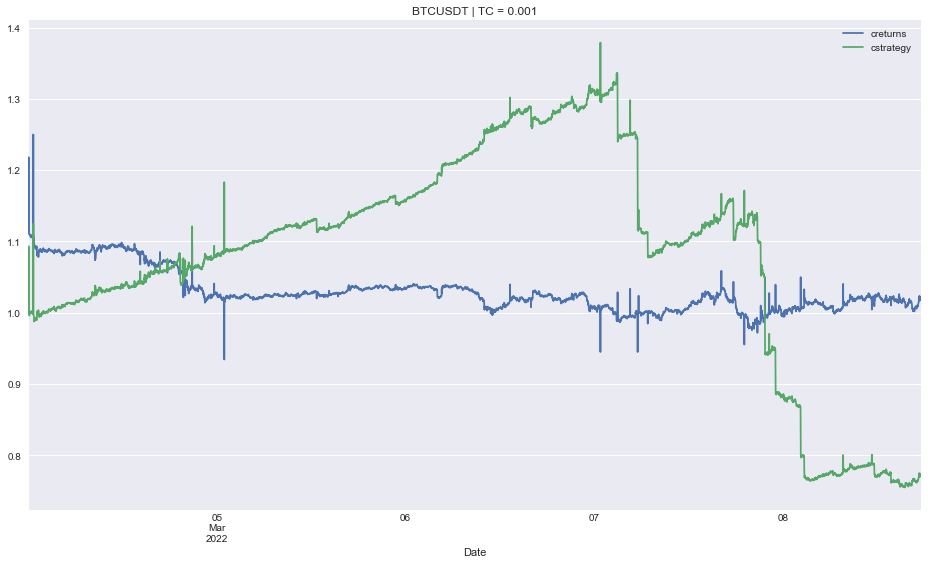

In [10]:
#lets plot the result against the buy and hold benchmark

crossoverVec.plot_results()

From the above plot we can see that the backtested despite profitable, does not outperforms the buy and hold benchmark. What we see from the graph is inded the multiple of the strategy computed by taking the exp of the cumulative returns of the strategy. To obtain the wealth evolution it will be sufficient to multiply the multiple for the invested amount.

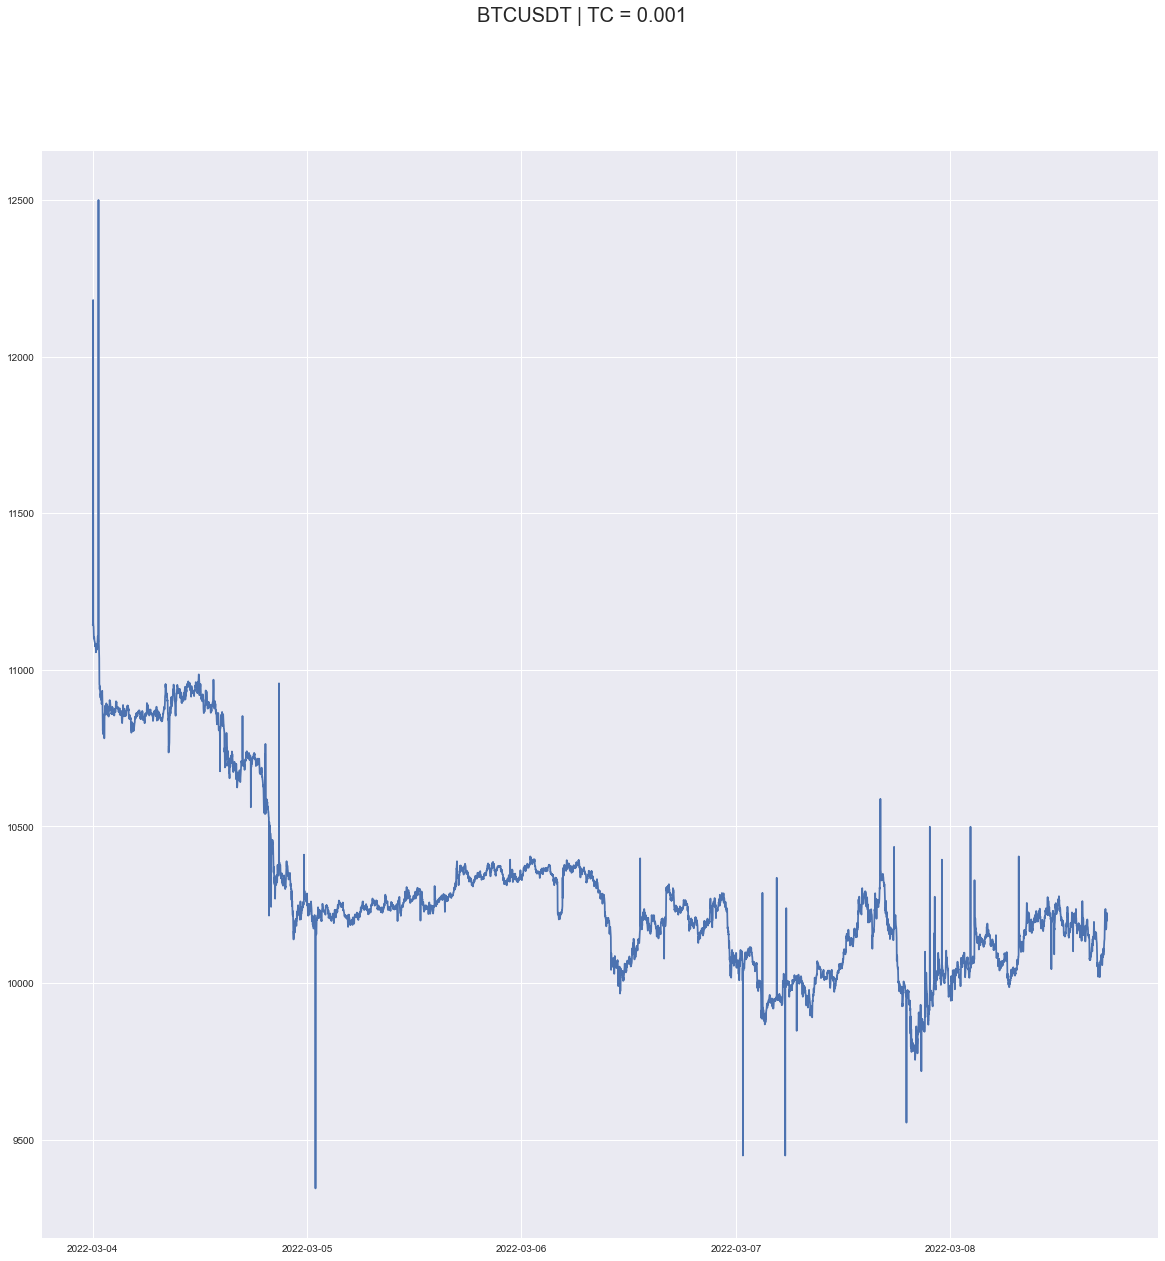

In [11]:
# lets look at the plots of the evolution of the amount, namely the time series
# associated with the multiple times the invested amount.

crossoverVec.plot_performance()

In [12]:
#lets now look at the vectorized dataset that resumes all the strategy

res = crossoverVec.results

res.head(10)


,Close,returns,EMA_S,EMA_L,positions,strategy,trades,total_sreturn,drawdown,creturns,cstrategy
Date,,,,,,,,,,,
2022-03-04 00:01:00,42458.8,0.108338,40497.025000,40388.037500,1,NaN,0.0,0.108338,0.000000,1.114425,NaN
2022-03-04 00:02:00,42453.7,-0.000120,41283.595349,41146.536386,1,-0.000120,0.0,0.108218,-0.000120,1.114291,0.999880
2022-03-04 00:03:00,42459.3,0.000132,41670.937649,41525.510945,1,0.000132,0.0,0.108350,0.000000,1.114438,1.000012
2022-03-04 00:04:00,46409.5,0.088958,43031.250023,42706.906335,1,0.088958,0.0,0.197308,0.000000,1.218119,1.093048
2022-03-04 00:05:00,42484.9,-0.088355,42889.344050,42660.073139,1,-0.088355,0.0,0.108953,-0.088355,1.115110,1.000615
2022-03-04 00:06:00,42444.5,-0.000951,42782.154504,42619.313594,1,-0.000951,0.0,0.108001,-0.089307,1.114049,0.999663
2022-03-04 00:07:00,42436.8,-0.000181,42703.584690,42587.765202,1,-0.000181,0.0,0.107820,-0.089488,1.113847,0.999482
2022-03-04 00:08:00,42360.8,-0.001793,42629.006737,42551.358874,1,-0.001793,0.0,0.106027,-0.091281,1.111852,0.997692
2022-03-04 00:09:00,42289.9,-0.001675,42557.775276,42511.985433,1,-0.001675,0.0,0.104352,-0.092956,1.109992,0.996022


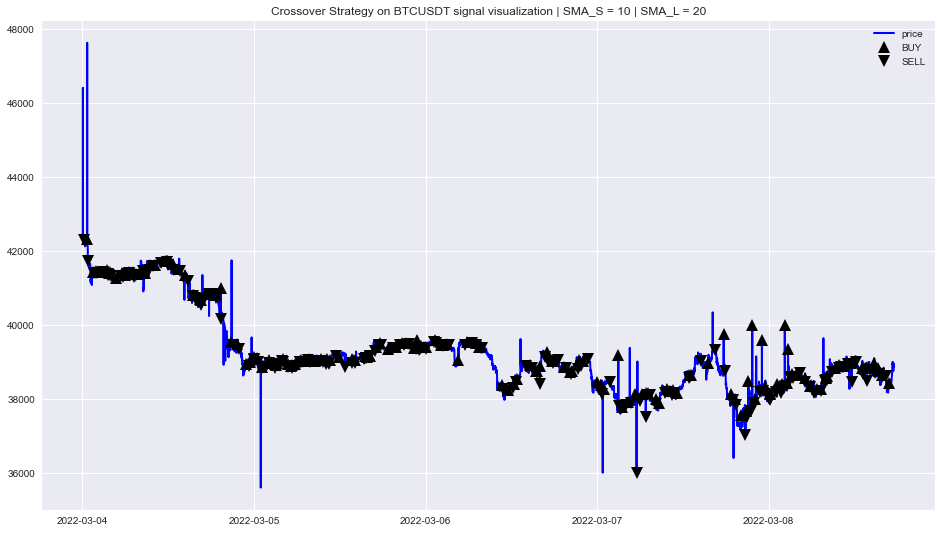

In [13]:
#With the following code we can visualize the signal

res['orders'] = res['positions'].diff().fillna(0)
        

fig = plt.figure(figsize=(16,9))


plt.plot(res.Close, color = 'b', lw = 2.)

plt.plot(res.query('trades !=0 & orders == 2.0').Close.index, res.query('trades !=0 & orders == 2.0').Close,
         '^', markersize = 12, color = 'k', lw = 1.)

plt.plot(res.query('trades !=0 & orders == -2.0').Close.index, res.query('trades !=0 & orders == -2.0').Close,
         'v', markersize = 12, color = 'k', lw = 1.)

plt.legend(['price', 'BUY', 'SELL'])

title = 'Crossover Strategy on BTCUSDT signal visualization | SMA_S = {} | SMA_L = {}'.format(10,20)
plt.title(title)

plt.show()

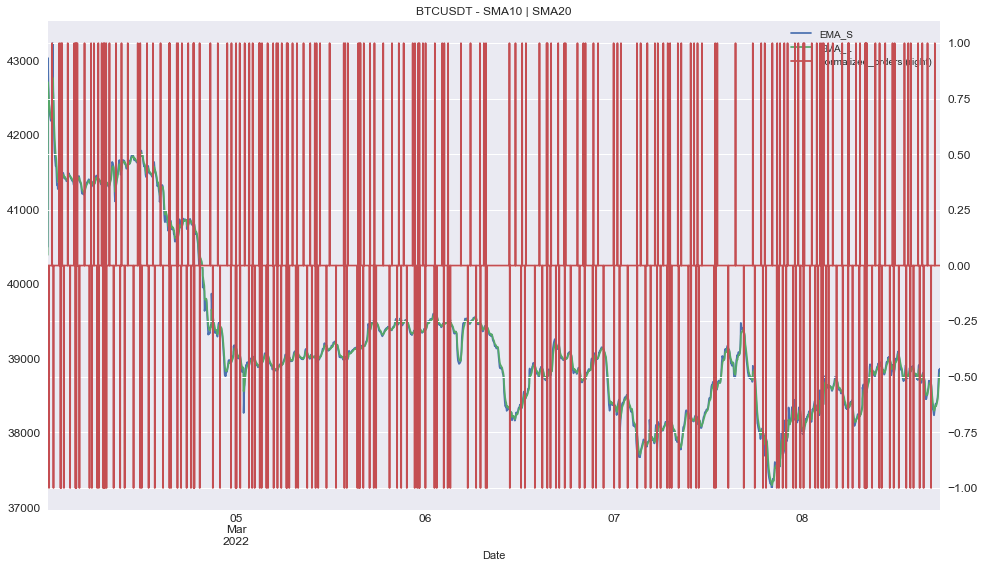

In [14]:
#we can visualize the orders in a more classical way, for which will be easier to see the holding time

res['normalized_orders'] = res.orders / 2.0


res.loc[:, ["EMA_S", "EMA_L", "normalized_orders"]].plot(figsize = (16, 9), fontsize = 12, secondary_y = "normalized_orders",
                                                title = "BTCUSDT - SMA{} | SMA{}".format(10, 20))
plt.show()



In [15]:
#We can optimize the strategy performing a grid search with the method optimize_strategy

SMA_S_range = [10, 32, 2] #[lower_bound, upper_bound, step]
SMA_L_range = [20, 160, 10]

crossoverVec.optimize_strategy(SMA_S_range, SMA_L_range)

Return perc. 4.464944788364421 | EMA_S = 22 | EMA_L = 20
STRATEGY PERFORMANCE | INSTRUMENT = BTCUSDT |
----------------------------------------------------------------------------------------------------
TRADING PERFORMANCE MEASURES:


Number of Trades: 456.0
Number of Winners: 227
Number of Loosers: 229.0


Win Ratio: 0.4978
Loose Ratio: 0.5022


Terminal Wealth: 10201.6572
Maximum Drawdown: -0.291
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         4.4649
Multiple (Buy-and-Hold Benchmark):     1.0202
--------------------------------------
Out-/Underperformance:       3.4447


Sharpe Ratio:                1.0616


Despite the result may seem a bit better a *true story is* it may be *too good to be true*. 
Vectorized backtesting presents two major problems:

- **Data Snooping / "Over fitting"** : Will the fitted parameters work with fresh new data as well?
- **Look-Ahead-Bias** : We know all future prices and moving averages from the very first datapoint.

The natural question is, what can we do to reduce as much as possible the above two major problems?

- **Train/Test Split**: 

Split the dataset into two datasets one for training one for testing. That means the training data should be used
for working on the optimal model, the test data should be used with the best parameters gained on the training phase.

- **Bootstrapping/Cross Validation**:

Iterate a train test split in a rolling window across all the dataframe. This technique is quite computational expensive, however there are some python module from scikit learn that do this job pretty well. However it will not be object of this discussion.

- **Consider another more advanced Backtest technique**:
We will provide full details of another backtesting technique in the very next session.

In [16]:
#Train test split. 
import math

dataset = pd.read_csv('bitcoin_minute.csv')

#divide the sample into 70% of the dataset size of training data, and the remaining 30% for testing data

split_size = math.ceil(dataset.shape[0] * 0.7)

train_dataset = dataset[:split_size]
test_dataset = dataset[split_size:]

In [17]:
train_dataset.to_csv('train_data.csv')
test_dataset.to_csv('test_data.csv')

In [18]:
crossTrain = DoubleCrossover(symbol = 'BTCUSDT', #symbol of the cryptocurrency
                             interval = '1m', #granularity of the bar
                             start = '2022-03-04', #starting date, ending date is optional
                             tc = 0.001, #trading costs (just the commissions, other costs are omitted)
                             amount = 10000, #trader amount to be invested
                             filepath = 'train_data.csv') #data provider

In [20]:
crossTrain.test_strategy(emas = [10,20])

STRATEGY PERFORMANCE | INSTRUMENT = BTCUSDT |
----------------------------------------------------------------------------------------------------
TRADING PERFORMANCE MEASURES:


Number of Trades: 470.0
Number of Winners: 212
Number of Loosers: 258.0


Win Ratio: 0.4511
Loose Ratio: 0.5489


Terminal Wealth: 9956.1672
Maximum Drawdown: -0.291
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.0847
Multiple (Buy-and-Hold Benchmark):     0.9956
--------------------------------------
Out-/Underperformance:       0.0891


Sharpe Ratio:                1.3318


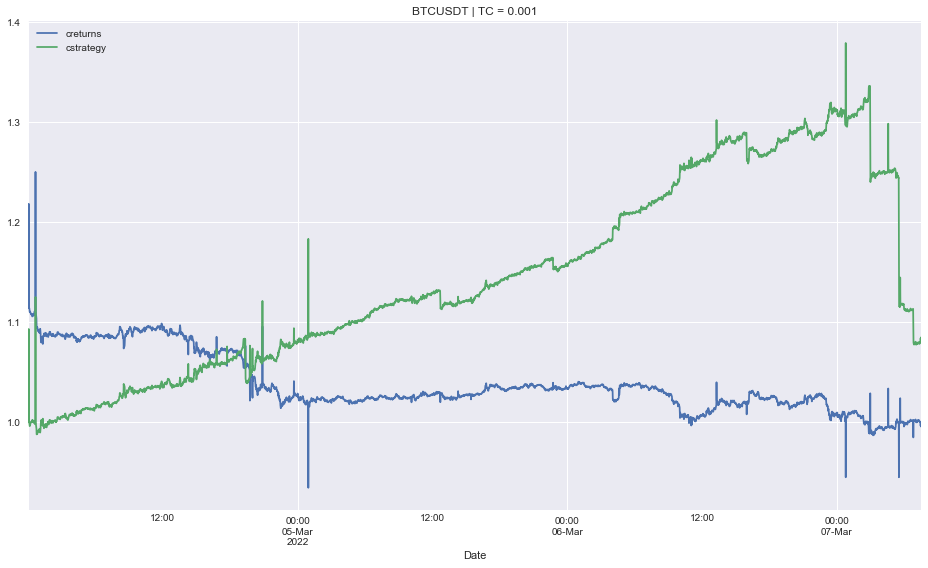

In [21]:
crossTrain.plot_results()

In [22]:
SMA_S_range = [10, 22, 2] #[lower_bound, upper_bound, step]
SMA_L_range = [20, 120, 10]

crossTrain.optimize_strategy(SMA_S_range, SMA_L_range)

Return perc. 1.084681968222377 | EMA_S = 10 | EMA_L = 20
STRATEGY PERFORMANCE | INSTRUMENT = BTCUSDT |
----------------------------------------------------------------------------------------------------
TRADING PERFORMANCE MEASURES:


Number of Trades: 470.0
Number of Winners: 212
Number of Loosers: 258.0


Win Ratio: 0.4511
Loose Ratio: 0.5489


Terminal Wealth: 9956.1672
Maximum Drawdown: -0.291
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.0847
Multiple (Buy-and-Hold Benchmark):     0.9956
--------------------------------------
Out-/Underperformance:       0.0891


Sharpe Ratio:                1.3318


In [23]:
#This strategy outperforms the benchmark slightly better than the previous one
#Now we run the optimized strategy on the test set

crossTest = DoubleCrossover(symbol = 'BTCUSDT', #symbol of the cryptocurrency
                             interval = '1m', #granularity of the bar
                             start = '2022-03-04', #starting date, ending date is optional
                             tc = 0.001, #trading costs (just the commissions, other costs are omitted)
                             amount = 10000, #trader amount to be invested
                             filepath = 'test_data.csv') #data provider

In [25]:
crossTest.test_strategy(emas=[18,20])

STRATEGY PERFORMANCE | INSTRUMENT = BTCUSDT |
----------------------------------------------------------------------------------------------------
TRADING PERFORMANCE MEASURES:


Number of Trades: 162.0
Number of Winners: 66
Number of Loosers: 96.0


Win Ratio: 0.4074
Loose Ratio: 0.5926


Terminal Wealth: 10196.6817
Maximum Drawdown: -0.1028
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         0.7427
Multiple (Buy-and-Hold Benchmark):     1.0197
--------------------------------------
Out-/Underperformance:       -0.277


Sharpe Ratio:                0.8648


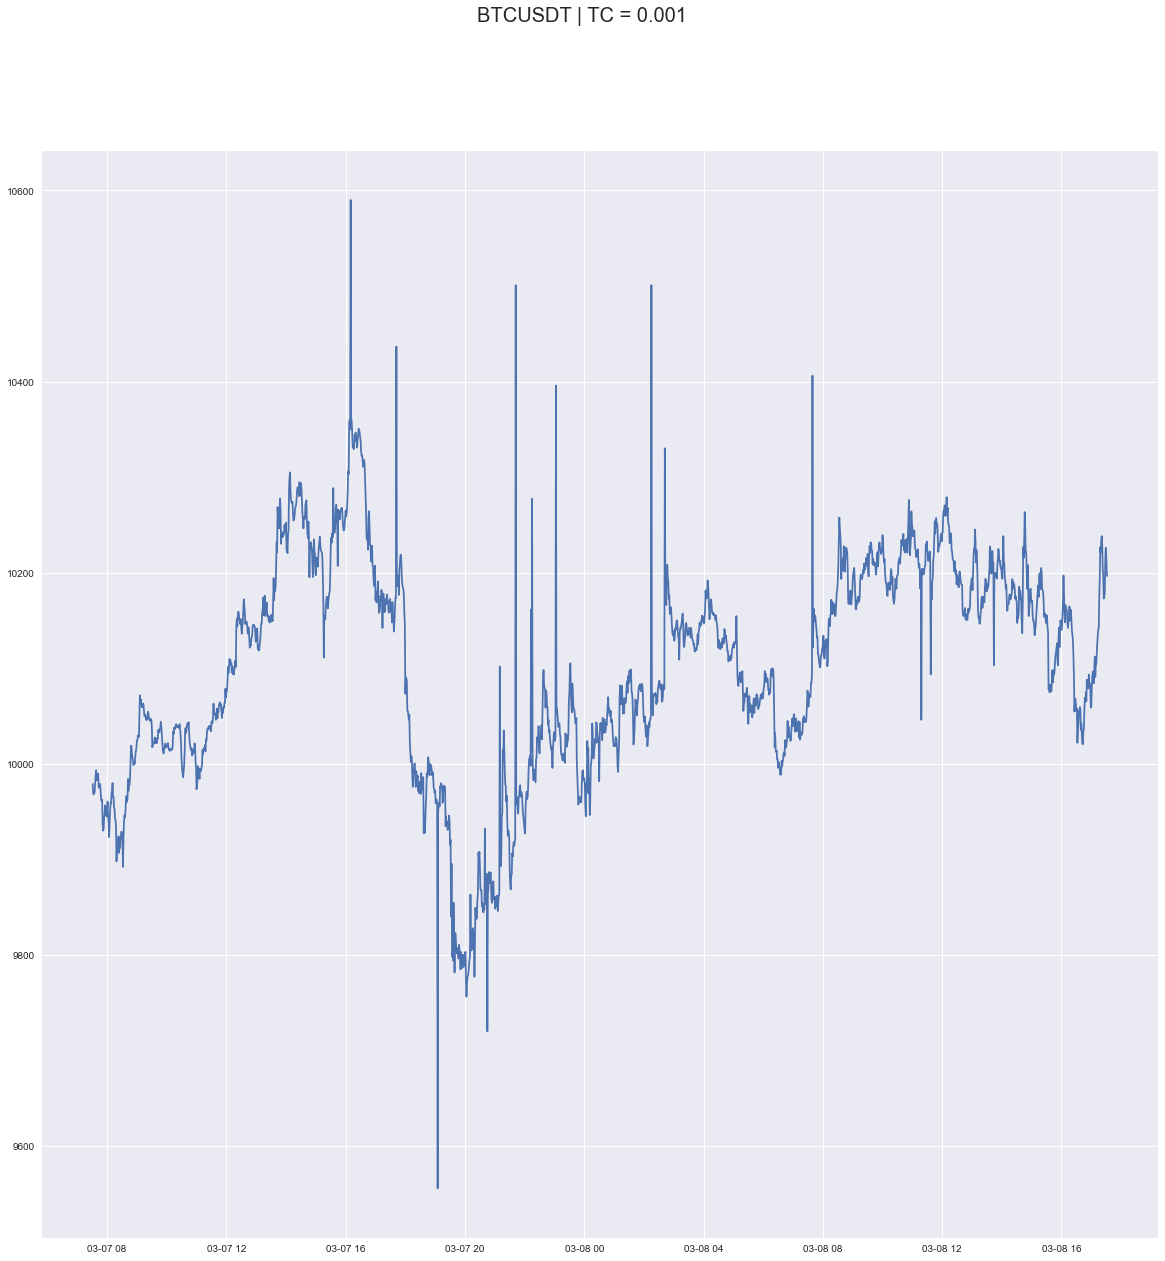

In [26]:
crossTest.plot_performance()

In [28]:
#We can test it also on the fixed 10,20 SMAS

crossTest.test_strategy(emas=[10,20])

STRATEGY PERFORMANCE | INSTRUMENT = BTCUSDT |
----------------------------------------------------------------------------------------------------
TRADING PERFORMANCE MEASURES:


Number of Trades: 194.0
Number of Winners: 73
Number of Loosers: 121.0


Win Ratio: 0.3763
Loose Ratio: 0.6237


Terminal Wealth: 10196.6817
Maximum Drawdown: -0.1028
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         0.7143
Multiple (Buy-and-Hold Benchmark):     1.0197
--------------------------------------
Out-/Underperformance:       -0.3054


Sharpe Ratio:                0.8648


### Conclusion of Part 1 ###

We have seen how a vectorized backtesting works, how to reduce look ahead bias and overfitting. The key point is that vectorized backtesting provides a fast way of screening a lot of strategies that are unprofitable. It can be used as a first step for a comprehensive backtesting.

# Part 2: Event Driven Backtesting

We start this session by quickly wrapping up the pros and cons of Vectorized Backtesting:

**PROS:**

- Simple Code
- Fast and efficient
- Test/SCreen many strategies and settings at once

**CONS:**

- Simplification (we invest amounts or units at bid and ask prices)
- Hard to code more complex strategies in vectorized way
- No path-dependent and recursive Strategies
- Look Ahead Bias (all positions and trades are determined simultaneously, but new data arrives incrementally)

Event Driven Backtesting is an iterative method that allows to make room for more complex strategy, can be used after Vectorized Backtesting since it is more realistic and coding-wise is more close to the implementation of a trading bot.
In event driven backtesting the data are considered one by one, as it is in a trading environment, indeed they are received one at a time exactly as in a real trading environment. In this sense, we won't have any lookahead bias. Other problems may arise from a more complex coding perspective.

Mainly iterative backtesting simulates an agent that buys and sells an asset with some specific given rules. Many modern backtesting engine are modelled on this kind of backtesting, and it allows the quants to add more modern techniques such as machine learning based models and some reinforcement learning tools (like the Reinassance hedge fund did).

In [29]:
#We import the python module with the iterative backtesting class for crossover.
#The code is pretty much involved and some of the technicalities are explained in the code.
#We save tedious details for further questions.

from CrossoverIterative import Crossover2

In [30]:
crossIter = Crossover2(symbol = 'BTCUSDT', #symbol of the cryptocurrency
                       interval = '1m', #granularity of the bar
                       start = '2022-03-04', #starting date, ending date is optional
                       commissions = 0.001, #trading costs (just the commissions, other costs are omitted)
                       amount = 10000, #trader amount to be invested
                       filepath = 'bitcoin_minute.csv') #data provider, alternatively set binance = True

In [32]:
#the test_strategy provides a list of trades based on the rules given on_data which uses the inheritance
#of the EventDrivenBacktester parent class.

crossIter.test_strategy(emas=[10,20])

....................................................................................................
Testing Crossover Strategy | BTCUSDT | EMA_S = 10 & EMA_L = 20
....................................................................................................
2022-03-04 00:01:00+00:00 |  Buying 0.0236 for 42458.801
2022-03-04 00:12:00+00:00 |  Selling 0.0236 for 42296.899
2022-03-04 00:12:00+00:00 |  Selling 0.0236 for 42296.899
2022-03-04 00:35:00+00:00 |  Buying 0.0236 for 42318.801
2022-03-04 00:35:00+00:00 |  Buying 0.0236 for 42318.801
2022-03-04 00:46:00+00:00 |  Selling 0.0236 for 41730.899
2022-03-04 00:46:00+00:00 |  Selling 0.0239 for 41730.899
2022-03-04 01:30:00+00:00 |  Buying 0.0239 for 41442.101
2022-03-04 01:30:00+00:00 |  Buying 0.0241 for 41442.101
2022-03-04 01:40:00+00:00 |  Selling 0.0241 for 41397.199
2022-03-04 01:40:00+00:00 |  Selling 0.0241 for 41397.199
2022-03-04 01:43:00+00:00 |  Buying 0.0241 for 41440.401
2022-03-04 01:43:00+00:00 |  Buying 0.0241 fo

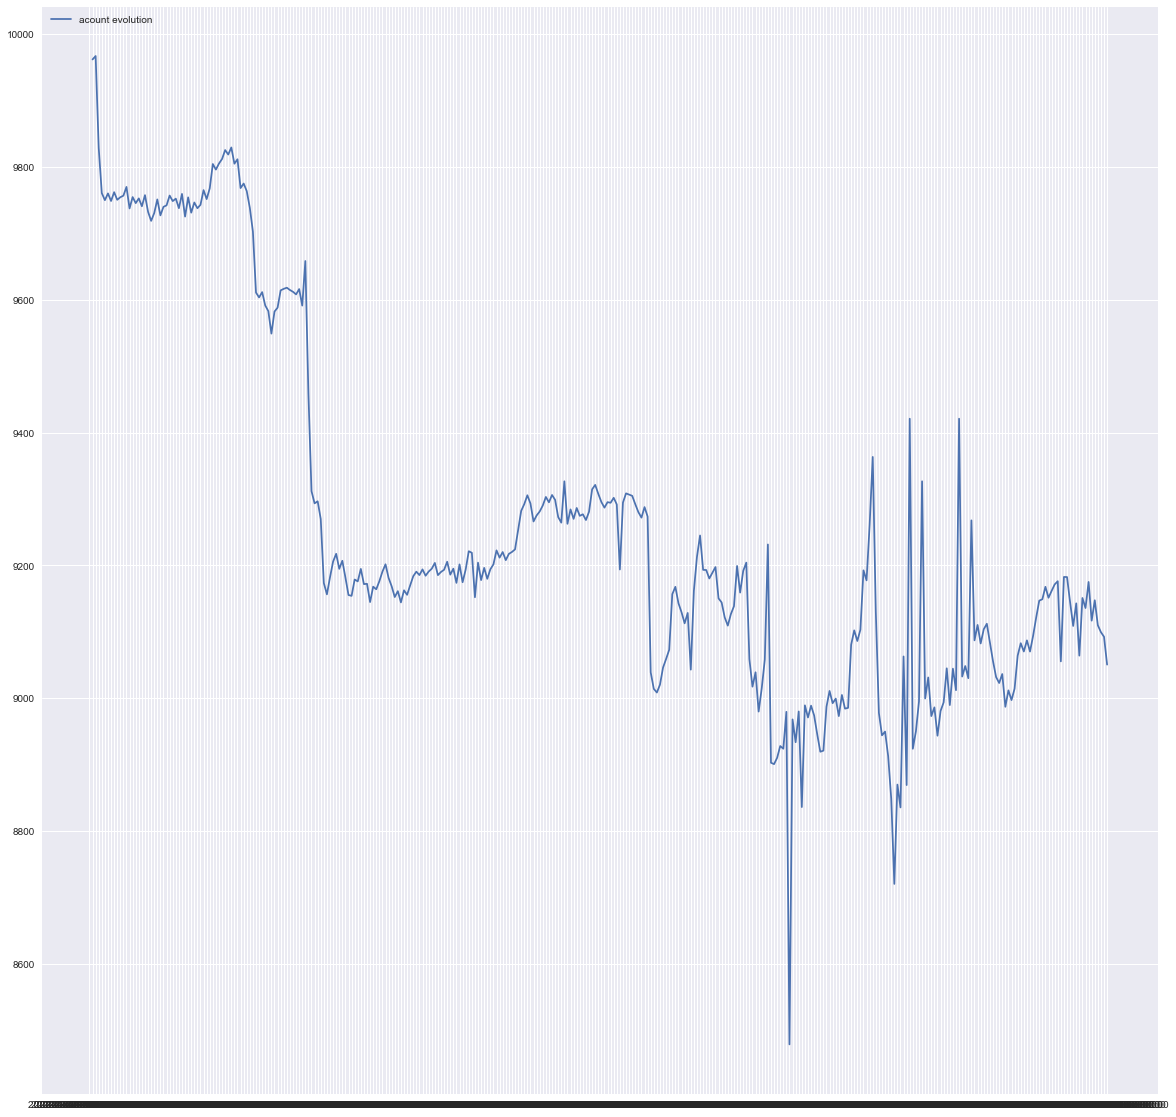

In [33]:
#We can already see that the performance is a bit worse than the Vectorized Backtesting class

crossIter.plot_performance(amount = 10000)

In [34]:
crossIter.print_performance()

+++++++++++ PERFORMANCE +++++++++++++
----------------------------------------------------------------------------------------------------
Number of trades 660.0
Final account balance 8199.909327700045
Number of winning trades 206
Number of loosing trades 454.0
Win Ratio 0.31
Loose Ratio 0.69
Maximum Drawdown -0.1617
Sharpe Ratio -0.0624


# Conclusions

We have outlined the efficiency of the iterative backtesting. We can point out that one of its shortfall consists in sending too many signals. Therefore, Vectorized Backtesting and the Event driven backtesting could be teamed up together, running firstly the vectorized backtesting with a train test split and then using the iterative backtest presented in this session to have a little more realistic check.


From The backtesting perspective, when looking at performance and drawdowns it sparks the problem of the size of each trade and the proper entry and exit levels with the stop losses and the take profit. Having a small window, adding a stop loss could minimize the maximum drawdown and increase the overall sharpe ratio of the strategy, resulting a more controlled and secure strategy from the risk point of view.